# Civil Engineering Machine Learning Project
## Damage evaluation of reinforced concrete beams with varying thickness using the acoustic emission technique


***
## 1. Data Extraction

In [431]:
"""
Created on Tue Jul 18 03:12:39 2017

@author: Aamir
"""
%matplotlib inline

### Import Libraries

In [432]:

import os
import scipy.io
import numpy as np
import pandas as pd
from datetime import datetime

import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.models import load_model
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble.gradient_boosting import GradientBoostingClassifier
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import accuracy_score
import xgboost as xgb

from IPython.display import SVG
import matplotlib.pyplot as plt

In [433]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

### Import and select relevant data 

In [434]:
temp1 = pd.read_excel("concrete-damage-data.xlsx")

In [435]:
temp2 = pd.read_excel("Type 1.xlsx", sheetname="B3")

In [436]:
temp1.shape, temp2.shape

((258735, 37), (162644, 19))

In [437]:
#temp1.dtypes, temp2.dtypes

In [438]:
train = temp1.iloc[:,0:20]
test = temp2.iloc[:,0:20]

In [439]:
train = train[train.ID!='ID']
train.dropna(inplace=True)
test = test[test.ID!='ID']
test.dropna(inplace=True)

In [440]:
train.head()

,ID,DDD,HH:MM:SS.mmmuuun,PARA1,CH,RISE,COUN,ENER,DURATION,AMP,A-FRQ,RMS,ASL,PCNTS,THR,R-FRQ,I-FRQ,SIG-STRNGTH,ABS-ENERGY,DAMAGE
3,1,0,00:01:13.212000,0.0143,2,21,4,2,134,51,30,0.0002,13,2,45,17,95,13088,202.701,0.0
5,1,0,00:01:13.505000,0.0131,4,9,5,2,114,52,44,0.0002,13,1,45,38,111,14372,260.846,0.0
12,1,0,00:01:14.793000,0.0131,2,1,1,0,2,47,500,0.0002,14,1,45,0,1000,283.65,6.438,0.0
14,1,0,00:01:14.918000,0.0119,2,1,2,0,55,45,36,0.0002,14,1,45,18,1000,4188,52.109,0.0
21,1,0,00:01:15.187000,0.0092,2,27,12,8,442,57,27,0.0004,16,2,45,24,74,51280,1296,0.0


In [441]:
test.head()

,ID,DDD,HH:MM:SS.mmmuuun,PARA1,CH,RISE,COUN,ENER,DURATION,AMP,A-FRQ,RMS,ASL,PCNTS,THR,R-FRQ,I-FRQ,SIG-STRNGTH,ABS-ENERGY
2,1,0,00:01:15.130000,0.0095,1,99,7,5,296,50,24,0.0004,15,4,45,15,40,35639,644.604
4,1,0,00:01:15.489000,0.0122,1,81,2,1,134,45,15,0.0004,18,1,45,18,12,8711,86.691
11,1,0,00:01:16.186000,0.0137,1,1,2,1,93,46,22,0.0002,14,1,45,10,1000,8583,105.235
18,1,0,00:01:17.331000,0.0134,1,1,1,0,8,48,125,0.0004,15,1,45,0,1000,1302,26.894
20,1,0,00:01:17.435000,0.0131,1,37,2,0,39,48,51,0.0004,16,2,45,0,54,5158,87.457


In [442]:
train.reset_index(drop=True,inplace=True)
test.reset_index(drop=True,inplace=True)

### Check data frame structure 

In [443]:
train.shape, test.shape

((127718, 20), (80124, 19))

In [444]:
train.dtypes, test.dtypes

(ID                   object
 DDD                  object
 HH:MM:SS.mmmuuun     object
 PARA1                object
 CH                   object
 RISE                 object
 COUN                 object
 ENER                 object
 DURATION             object
 AMP                  object
 A-FRQ                object
 RMS                  object
 ASL                  object
 PCNTS                object
 THR                  object
 R-FRQ                object
 I-FRQ                object
 SIG-STRNGTH          object
 ABS-ENERGY           object
 DAMAGE              float64
 dtype: object, ID                  object
 DDD                 object
 HH:MM:SS.mmmuuun    object
 PARA1               object
 CH                  object
 RISE                object
 COUN                object
 ENER                object
 DURATION            object
 AMP                 object
 A-FRQ               object
 RMS                 object
 ASL                 object
 PCNTS               object
 THR         

In [445]:
train.head(), test.head()

(  ID DDD HH:MM:SS.mmmuuun   PARA1 CH RISE COUN ENER DURATION AMP A-FRQ  \
 0  1   0  00:01:13.212000  0.0143  2   21    4    2      134  51    30   
 1  1   0  00:01:13.505000  0.0131  4    9    5    2      114  52    44   
 2  1   0  00:01:14.793000  0.0131  2    1    1    0        2  47   500   
 3  1   0  00:01:14.918000  0.0119  2    1    2    0       55  45    36   
 4  1   0  00:01:15.187000  0.0092  2   27   12    8      442  57    27   
 
       RMS ASL PCNTS THR R-FRQ I-FRQ SIG-STRNGTH ABS-ENERGY  DAMAGE  
 0  0.0002  13     2  45    17    95       13088    202.701     0.0  
 1  0.0002  13     1  45    38   111       14372    260.846     0.0  
 2  0.0002  14     1  45     0  1000      283.65      6.438     0.0  
 3  0.0002  14     1  45    18  1000        4188     52.109     0.0  
 4  0.0004  16     2  45    24    74       51280       1296     0.0  ,
   ID DDD HH:MM:SS.mmmuuun   PARA1 CH RISE COUN ENER DURATION AMP A-FRQ  \
 0  1   0  00:01:15.130000  0.0095  1   99    7    5

***
## 2. Data Cleaning
### Check and fill missing values 

In [446]:
train.count(), test.count()

(ID                  127718
 DDD                 127718
 HH:MM:SS.mmmuuun    127718
 PARA1               127718
 CH                  127718
 RISE                127718
 COUN                127718
 ENER                127718
 DURATION            127718
 AMP                 127718
 A-FRQ               127718
 RMS                 127718
 ASL                 127718
 PCNTS               127718
 THR                 127718
 R-FRQ               127718
 I-FRQ               127718
 SIG-STRNGTH         127718
 ABS-ENERGY          127718
 DAMAGE              127718
 dtype: int64, ID                  80124
 DDD                 80124
 HH:MM:SS.mmmuuun    80124
 PARA1               80124
 CH                  80124
 RISE                80124
 COUN                80124
 ENER                80124
 DURATION            80124
 AMP                 80124
 A-FRQ               80124
 RMS                 80124
 ASL                 80124
 PCNTS               80124
 THR                 80124
 R-FRQ               

No missing data. Incomplete entries have already been removed.

### Convert to numeric columns 

In [447]:
train['ID'] = train['ID'].astype(int)
train['DDD'] = train['DDD'].astype(int)
train['PARA1'] = train['PARA1'].astype(float)
train['CH'] = train['CH'].astype(int)
train['RISE'] = train['RISE'].astype(int)
train['COUN'] = train['COUN'].astype(int)
train['ENER'] = train['ENER'].astype(int)
train['DURATION'] = train['DURATION'].astype(int)
train['AMP'] = train['AMP'].astype(int)
train['A-FRQ'] = train['A-FRQ'].astype(int)
train['RMS'] = train['RMS'].astype(float)
train['ASL'] = train['ASL'].astype(int)
train['PCNTS'] = train['PCNTS'].astype(int)
train['THR'] = train['THR'].astype(int)
train['R-FRQ'] = train['R-FRQ'].astype(int)
train['I-FRQ'] = train['I-FRQ'].astype(int)
train['SIG-STRNGTH'] = train['SIG-STRNGTH'].astype(float)
train['ABS-ENERGY'] = train['ABS-ENERGY'].astype(float)
train['DAMAGE'] = train['DAMAGE'].astype(int)

train.dtypes

ID                    int32
DDD                   int32
HH:MM:SS.mmmuuun     object
PARA1               float64
CH                    int32
RISE                  int32
COUN                  int32
ENER                  int32
DURATION              int32
AMP                   int32
A-FRQ                 int32
RMS                 float64
ASL                   int32
PCNTS                 int32
THR                   int32
R-FRQ                 int32
I-FRQ                 int32
SIG-STRNGTH         float64
ABS-ENERGY          float64
DAMAGE                int32
dtype: object

In [448]:
test['ID'] = test['ID'].astype(int)
test['DDD'] = test['DDD'].astype(int)
test['PARA1'] = test['PARA1'].astype(float)
test['CH'] = test['CH'].astype(int)
test['RISE'] = test['RISE'].astype(int)
test['COUN'] = test['COUN'].astype(int)
test['ENER'] = test['ENER'].astype(int)
test['DURATION'] = test['DURATION'].astype(int)
test['AMP'] = test['AMP'].astype(int)
test['A-FRQ'] = test['A-FRQ'].astype(int)
test['RMS'] = test['RMS'].astype(float)
test['ASL'] = test['ASL'].astype(int)
test['PCNTS'] = test['PCNTS'].astype(int)
test['THR'] = test['THR'].astype(int)
test['R-FRQ'] = test['R-FRQ'].astype(int)
test['I-FRQ'] = test['I-FRQ'].astype(int)
test['SIG-STRNGTH'] = test['SIG-STRNGTH'].astype(float)
test['ABS-ENERGY'] = test['ABS-ENERGY'].astype(float)

test.dtypes

ID                    int32
DDD                   int32
HH:MM:SS.mmmuuun     object
PARA1               float64
CH                    int32
RISE                  int32
COUN                  int32
ENER                  int32
DURATION              int32
AMP                   int32
A-FRQ                 int32
RMS                 float64
ASL                   int32
PCNTS                 int32
THR                   int32
R-FRQ                 int32
I-FRQ                 int32
SIG-STRNGTH         float64
ABS-ENERGY          float64
dtype: object

In [449]:
train.to_excel("trainData.xlsx")
test.to_excel("testData.xlsx")

### Normalize Data

In [450]:
# mn = pd.DataFrame.mean(data)
# vr = pd.DataFrame.var(data)

# data.RISE = (data.RISE - mn.RISE) / vr.RISE
# data.COUN = (data.COUN - mn.COUN) / vr.COUN
# data.ENER = (data.ENER - mn.ENER) / vr.ENER
# data.DURATION = (data.DURATION - mn.DURATION) / vr.DURATION
# data.AMP = (data.AMP - mn.AMP) / vr.AMP
# data.A_FRQ = (data.A_FRQ - mn.A_FRQ) / vr.A_FRQ
# data.SIG_STRNGTH = (data.SIG_STRNGTH - mn.SIG_STRNGTH) / vr.SIG_STRNGTH
# data.ABS_ENERGY = (data.ABS_ENERGY - mn.ABS_ENERGY) / vr.ABS_ENERGY

In [451]:
train['HR'] = train['HH:MM:SS.mmmuuun'].apply(lambda x: x.hour)
train['MIN'] = train['HH:MM:SS.mmmuuun'].apply(lambda x: x.minute)
train['SEC'] = train['HH:MM:SS.mmmuuun'].apply(lambda x: x.second)
train['USEC'] = train['HH:MM:SS.mmmuuun'].apply(lambda x: x.microsecond)

In [452]:
test['HR'] = test['HH:MM:SS.mmmuuun'].apply(lambda x: x.hour)
test['MIN'] = test['HH:MM:SS.mmmuuun'].apply(lambda x: x.minute)
test['SEC'] = test['HH:MM:SS.mmmuuun'].apply(lambda x: x.second)
test['USEC'] = test['HH:MM:SS.mmmuuun'].apply(lambda x: x.microsecond)

In [453]:
train.head()

,ID,DDD,HH:MM:SS.mmmuuun,PARA1,CH,RISE,COUN,ENER,DURATION,AMP,...,THR,R-FRQ,I-FRQ,SIG-STRNGTH,ABS-ENERGY,DAMAGE,HR,MIN,SEC,USEC
0,1,0,00:01:13.212000,0.0143,2,21,4,2,134,51,...,45,17,95,13088.00,202.701,0,0,1,13,212000
1,1,0,00:01:13.505000,0.0131,4,9,5,2,114,52,...,45,38,111,14372.00,260.846,0,0,1,13,505000
2,1,0,00:01:14.793000,0.0131,2,1,1,0,2,47,...,45,0,1000,283.65,6.438,0,0,1,14,793000
3,1,0,00:01:14.918000,0.0119,2,1,2,0,55,45,...,45,18,1000,4188.00,52.109,0,0,1,14,918000
4,1,0,00:01:15.187000,0.0092,2,27,12,8,442,57,...,45,24,74,51280.00,1296.000,0,0,1,15,187000


In [454]:
test.head()

,ID,DDD,HH:MM:SS.mmmuuun,PARA1,CH,RISE,COUN,ENER,DURATION,AMP,...,PCNTS,THR,R-FRQ,I-FRQ,SIG-STRNGTH,ABS-ENERGY,HR,MIN,SEC,USEC
0,1,0,00:01:15.130000,0.0095,1,99,7,5,296,50,...,4,45,15,40,35639.0,644.604,0,1,15,130000
1,1,0,00:01:15.489000,0.0122,1,81,2,1,134,45,...,1,45,18,12,8711.0,86.691,0,1,15,489000
2,1,0,00:01:16.186000,0.0137,1,1,2,1,93,46,...,1,45,10,1000,8583.0,105.235,0,1,16,186000
3,1,0,00:01:17.331000,0.0134,1,1,1,0,8,48,...,1,45,0,1000,1302.0,26.894,0,1,17,331000
4,1,0,00:01:17.435000,0.0131,1,37,2,0,39,48,...,2,45,0,54,5158.0,87.457,0,1,17,435000


In [455]:
X = train.copy()
y = train['DAMAGE'].copy()
Z = test.copy()

In [456]:
X.drop('HH:MM:SS.mmmuuun',axis=1,inplace=True)
X.drop('DAMAGE',axis=1,inplace=True)

In [457]:
Z.drop('HH:MM:SS.mmmuuun',axis=1,inplace=True)

Split Train/Test Sets

In [458]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)

In [459]:
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((102174, 22), (25544, 22), (102174,), (25544,))

***
## 3. Train and Evaluate the Model

### XGBoost MODEL

### XGBoost Setup

In [460]:
# Specify the model
dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_valid, label=y_valid)
dtest = xgb.DMatrix(Z)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

### XGBoost training and evaluation

In [461]:
xgb_pars = {'min_child_weight': 50, 'eta': 0.1, 'colsample_bytree': 0.9, 'max_depth': 10,
'subsample': 0.9, 'lambda': 1., 'nthread': -1, 'booster' : 'gbtree', 'silent': 1,
'eval_metric': 'rmse', 'objective': 'reg:linear'}

model = xgb.train(xgb_pars, dtrain, 1000, watchlist, early_stopping_rounds=10,
      maximize=False, verbose_eval=1)

print('Modeling RMSLE %.5f' % model.best_score)

[0]	train-rmse:1.77085	valid-rmse:1.76855
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 10 rounds.
[1]	train-rmse:1.59381	valid-rmse:1.59175
[2]	train-rmse:1.43447	valid-rmse:1.43264
[3]	train-rmse:1.29107	valid-rmse:1.28944
[4]	train-rmse:1.16201	valid-rmse:1.16056
[5]	train-rmse:1.04586	valid-rmse:1.04457
[6]	train-rmse:0.941325	valid-rmse:0.940185
[7]	train-rmse:0.847253	valid-rmse:0.846244
[8]	train-rmse:0.762591	valid-rmse:0.761697
[9]	train-rmse:0.686396	valid-rmse:0.685608
[10]	train-rmse:0.617826	valid-rmse:0.617134
[11]	train-rmse:0.556123	valid-rmse:0.555523
[12]	train-rmse:0.500594	valid-rmse:0.500071
[13]	train-rmse:0.450619	valid-rmse:0.450164
[14]	train-rmse:0.405648	valid-rmse:0.405257
[15]	train-rmse:0.365184	valid-rmse:0.36485
[16]	train-rmse:0.328773	valid-rmse:0.328487
[17]	train-rmse:0.296007	valid-rmse:0.295761
[18]	train-rmse:0.266528	valid-rmse:0.266324
[19]	train-rmse:0.24001

[179]	train-rmse:0.008114	valid-rmse:0.011628
[180]	train-rmse:0.008101	valid-rmse:0.011606
[181]	train-rmse:0.008093	valid-rmse:0.011608
[182]	train-rmse:0.008083	valid-rmse:0.01161
[183]	train-rmse:0.008059	valid-rmse:0.011587
[184]	train-rmse:0.008046	valid-rmse:0.011559
[185]	train-rmse:0.008019	valid-rmse:0.011543
[186]	train-rmse:0.007993	valid-rmse:0.011537
[187]	train-rmse:0.007984	valid-rmse:0.011531
[188]	train-rmse:0.007966	valid-rmse:0.011547
[189]	train-rmse:0.007957	valid-rmse:0.011546
[190]	train-rmse:0.007945	valid-rmse:0.011525
[191]	train-rmse:0.007935	valid-rmse:0.011517
[192]	train-rmse:0.007927	valid-rmse:0.011516
[193]	train-rmse:0.00791	valid-rmse:0.011508
[194]	train-rmse:0.007899	valid-rmse:0.011494
[195]	train-rmse:0.007889	valid-rmse:0.011485
[196]	train-rmse:0.007882	valid-rmse:0.011493
[197]	train-rmse:0.007861	valid-rmse:0.011484
[198]	train-rmse:0.007852	valid-rmse:0.011476
[199]	train-rmse:0.007846	valid-rmse:0.011472
[200]	train-rmse:0.007834	valid-rmse

### Train/Validation Set Evaluation 

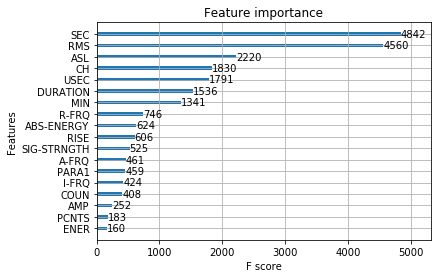

In [462]:
xgb.plot_importance(model, height=0.3)

### Prediction

In [463]:
# evaluate the model
pred = model.predict(dtest)
pred = np.exp(pred) - 1

In [465]:
y_pred <- predict(xgb, test.matrix(X_test[,-1]))

SyntaxError: invalid syntax (<ipython-input-465-f7698b9e7191>, line 1)

In [467]:
pred

array([  0.43643856,   0.39877129,   0.21250212, ...,  18.8371315 ,
        18.47843933,  18.75484848], dtype=float32)

In [466]:
# fit model no training data
model = xgb.XGBClassifier()
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='multi:softprob', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [468]:
# make predictions for test data
Z_pred = model.predict(Z)

In [469]:
predictions = [round(value) for value in Z_pred]

In [472]:
result = Z.copy()

In [473]:
result["DAMAGE"] = predictions

In [474]:
result.to_excel("resultTest.xlsx")

In [328]:
# evaluate predictions
accuracy = accuracy_score(y_valid, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 100.00%


### RandomTreeClassifier MODEL

### Check feature importance

In [311]:
clf = RandomForestClassifier(n_estimators=50, max_features='sqrt')
clf = clf.fit(X,y)

In [312]:
features = pd.DataFrame()
features['feature'] = X.columns
features['importance'] = clf.feature_importances_
features.sort_values(by=['importance'], ascending=True, inplace=True)
features.set_index('feature', inplace=True)

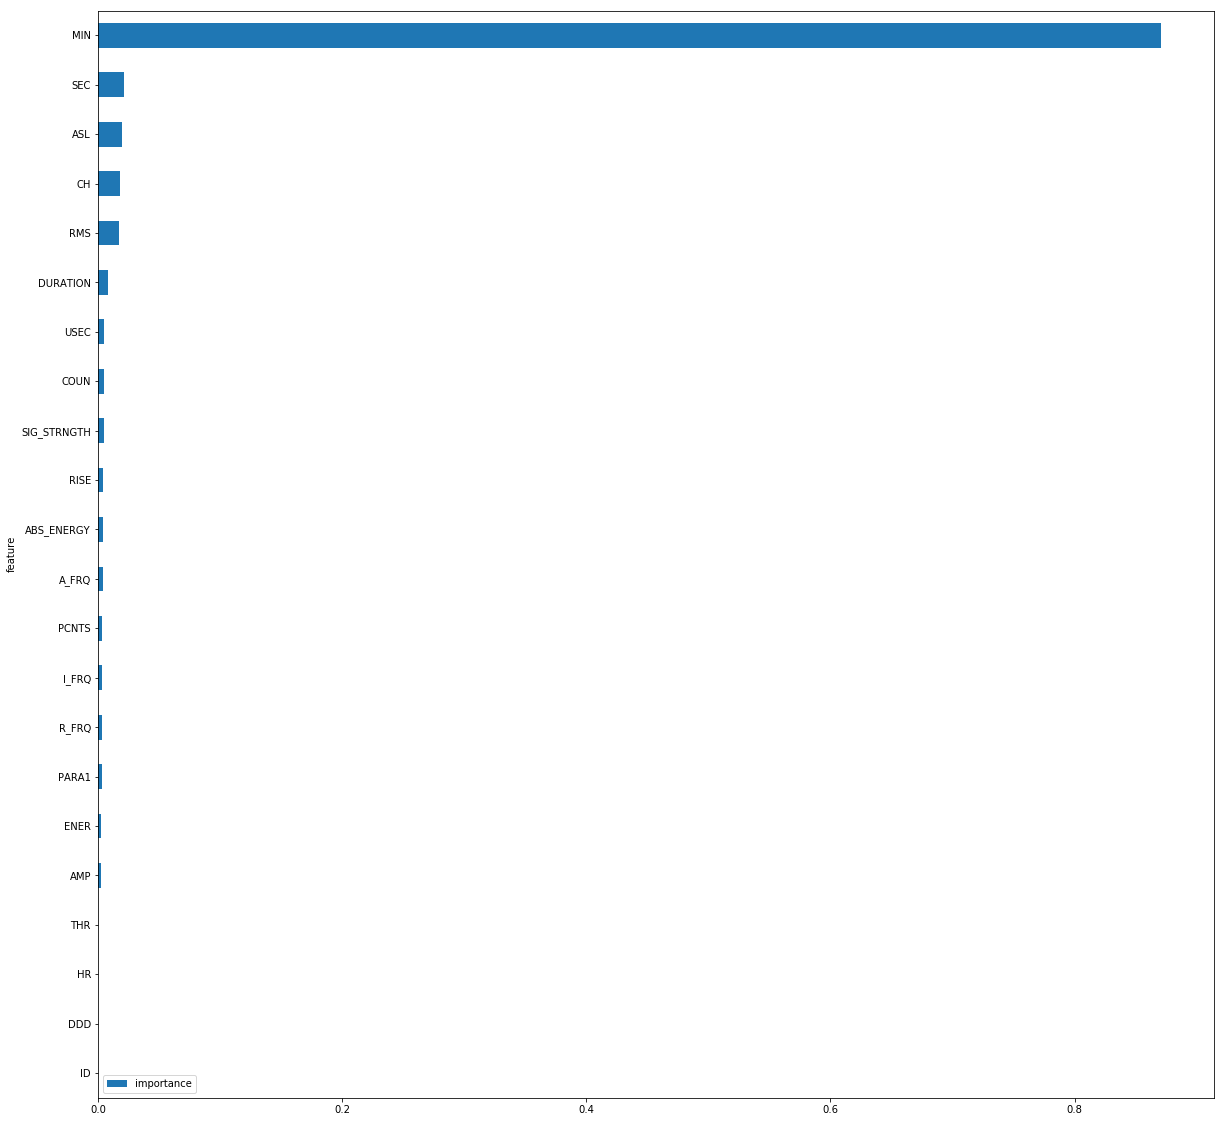

In [313]:
features.plot(kind='barh', figsize=(20, 20))

### Hyperparameter tuning

In [337]:
parameters = {'bootstrap': False, 'min_samples_leaf': 3, 'n_estimators': 50,
'min_samples_split': 10, 'max_features': 'sqrt', 'max_depth': 6}
model = RandomForestClassifier(**parameters)
model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=6, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [338]:
xval = cross_val_score(model, X_valid, y_valid, cv = 5, scoring='accuracy')
np.mean(xval)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:553: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=5.
  % (min_labels, self.n_folds)), Warning)


0.96492604190029385

In [356]:
p_y = model.predict(X_valid)

In [357]:
np.mean(p_y == y_valid)

0.9953805198872534

***
## 5. Predict the Test set

### Select test model features 

### Make predictions 

***
## 6. Save Results
### Create the Solution 

In [ ]:
my_solution.index.name

### Save to CSV file 

In [ ]:
my_solution.to_csv("my_solution_six.csv")

***
***
# Rough Work 

In [ ]:
%matplotlib inline